kaggleのhttps://www.kaggle.com/c/sf-crime を使って，San Franciscoで金曜日に犯罪が起こりやすいのかをベイズ統計的なあれで求める  
このnotebookと同じディレクトリのinput/crimetrain.csv にデータがある前提．データはkaggleのサイトからダウンロード可能  
詳細はスライドpdfを参照  

** このnotebookに出力されててる結果はnotebook全体をrunする度に結果が変わるのでrunするときは適宜読み替えるように **

In [116]:
import numpy as np
import pandas as pd
import scipy
%matplotlib inline

In [117]:
df = pd.read_csv("input/crimetrain.csv")

まずはデータを眺めてみる

In [118]:
df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [119]:
df[:10]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802


今回使うのはDayOfWeekだけなのでとりだす

In [120]:
df_of_DayOfWeek = df["DayOfWeek"]

２つのデータを抜き出す．今回は1000データずつ  
.sampleメソッドはランダムにデータをとってくるので，このnotebook全体をrunするとデータが変わるので後の処理結果は変わる(かも

In [121]:
sample_data_1 = df_of_DayOfWeek.sample(n=1000)
sample_data_2 = df_of_DayOfWeek.sample(n=1000) #ホントは上のデータと重複しないようにしないといけないけど今回は省略

In [122]:
friday_freq_of_data1 = sample_data_1.value_counts()["Friday"]
friday_freq_of_data2 = sample_data_2.value_counts()["Friday"]

### Cycle1

Hx:xの確率で金曜日に犯罪が起こる確率  
O:犯罪が起こる確率

data1からP(H|O)を求めたいので，ベイズの定理により(P(O|H)P(H)) / (sum P(O|H)P(H))を求めることになる．  
詳細はスライドpdf参照．  

手順は，  
1. 事前確率P(O|H)の関数を作る．今回は２項分布．(この関数は扱うデータによって求め方が異なると思われます)
2. (sum P(O|H)P(H))を求める
3. (P(O|H)P(H)) / (sum P(O|H)P(H))をHx毎に求める

ただし，P(H)は最初のCycleではどのHxでも同じ値(一定の分布と仮定)なので実際にはP(H|O) = (P(O|H)) / (sum P(O|H))になる．  
なので適当に簡略化しとく

In [123]:
# Hxの範囲．1〜100%
h_range = list(range(1,101))

In [124]:
# 事前確率を求める関数．引数hはHxに相当
priori1 = lambda h: scipy.misc.comb(1000, friday_freq_of_data1) * ((h/100)**friday_freq_of_data1) * (((100-h)/100)**(1000-friday_freq_of_data1))
# (sum P(O|H))を求める
sum_p_o1 = sum(map(priori1, h_range))
#  (P(O|H)) / (sum P(O|H))を求める関数
posterior1 = lambda h: priori1(h)/sum_p_o1
# (P(O|H)) / (sum P(O|H))をHx毎に求める
posterior_distribution1 = list(map(posterior1, h_range))

In [125]:
posterior_distribution1[:10]

[7.8888533326355781e-129,
 1.3689791999029254e-85,
 7.0334612401439259e-62,
 3.4608993880105374e-46,
 6.5910283811516076e-35,
 1.9607089872924647e-26,
 6.543535505679923e-20,
 7.9409761546585848e-15,
 7.476119473062983e-11,
 9.1535089035981626e-08]

いい感じなのでグラフを描く  
てきとうに描いてるけどちゃんと整形するときは下記とか参照  
http://own-search-and-study.xyz/2016/08/03/pandas%E3%81%AEplot%E3%81%AE%E5%85%A8%E5%BC%95%E6%95%B0%E3%82%92%E4%BD%BF%E3%81%84%E3%81%93%E3%81%AA%E3%81%99/

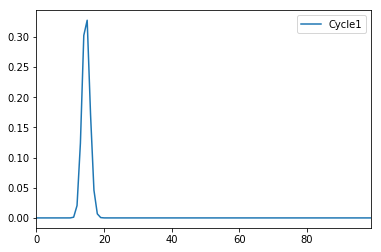

In [126]:
plot_df1 = pd.DataFrame(posterior_distribution1, columns=["Cycle1"])
plot_df1.plot()

In [127]:
plot_df1.describe()

,Cycle1
count,1.000000e+02
mean,1.000000e-02
std,4.882563e-02
min,0.000000e+00
25%,0.000000e+00
50%,1.535744e-120
75%,5.026806e-27
max,3.276004e-01


In [128]:
plot_df1["Cycle1"].argmax()

15

もし金曜日に犯罪が起こるのが少ないならP(H|O)のargmax(P(H|O)が最大のときのHx)は1/7(≒14.28％)を下回るはずだが，上回ってるので金曜日に犯罪が起こるのは正しそう  

In [129]:
print(plot_df1.iloc[14])
print(plot_df1.iloc[15])
print(plot_df1.iloc[16])
print(plot_df1.iloc[17])

Cycle1    0.302496
Name: 14, dtype: float64
Cycle1    0.3276
Name: 15, dtype: float64
Cycle1    0.170943
Name: 16, dtype: float64
Cycle1    0.045953
Name: 17, dtype: float64


### Cycle2
次はdata2でベイズ更新．Cycle1で求めたP(H|O)を新しいP(H)とする．  
つまりCycle1ではP(H)は一定と仮定したが，次はP(H)は一定ではなくdata1で求めた分布に従うとする．  
なのでP(H)は消えないので次はちゃんと(P(O|H)P(H)) / (sum P(O|H)P(H))を求める

In [130]:
# 事前確率を求める関数
priori2 = lambda h: scipy.misc.comb(1000, friday_freq_of_data2) * ((h/100)**friday_freq_of_data2) * (((100-h)/100)**(1000-friday_freq_of_data2))
# (sum P(O|H)P(H))を求める
sum_p_o2 = sum(map(lambda h: priori2(h)*posterior_distribution1[h-1] , h_range))
#  (P(O|H)P(H)) / (sum P(O|H)P(H))を求める関数
posterior2 = lambda h: (priori2(h)*posterior_distribution1[h-1])/sum_p_o2
# (P(O|H)) / (sum P(O|H))をHx毎に求める
posterior_distribution2 = list(map(posterior2, h_range))

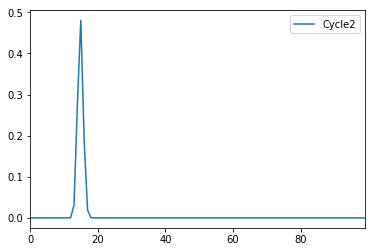

In [131]:
plot_df2 = pd.DataFrame(posterior_distribution2, columns=["Cycle2"])
plot_df2.plot()

Cycle1とCycle2で求めたP(H|O)の分布を重ねてみる

In [132]:
plot_df12 = pd.concat([plot_df1, plot_df2], axis=1)

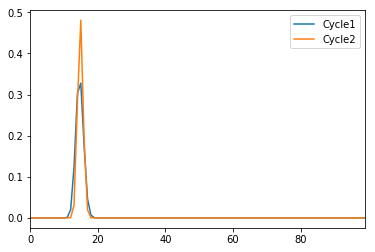

In [133]:
plot_df12.plot()

重ねてみるとCycle2で分布が変化したことがわかる

In [134]:
plot_df2["Cycle2"].argmax()

15

argmaxは15%で変わらないのでやはり金曜日に犯罪が起こりやすいと思われる．

最後に信頼区間と平均を求めておく(求め方は自信ない)

In [135]:
print("Cycle1")
print("mean:", np.mean(plot_df1))
print("Confidence interval:", scipy.stats.t.interval(0.95, len(plot_df1)-1, loc=np.mean(plot_df1), scale=stats.sem(plot_df1)))

Cycle1
mean: Cycle1    0.01
dtype: float64
Confidence interval: (array([ 0.00031194]), array([ 0.01968806]))


In [136]:
print("Cycle2")
print("mean:", np.mean(plot_df2))
print("Confidence interval:", scipy.stats.t.interval(0.95, len(plot_df2)-1, loc=np.mean(plot_df2), scale=stats.sem(plot_df2)))

Cycle2
mean: Cycle2    0.01
dtype: float64
Confidence interval: (array([-0.0015564]), array([ 0.0215564]))
